In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

### Collect data

In [4]:
DATASET_ID = 'canary_segmented'

In [5]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [6]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'canary.pickle'
df_loc

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/syllable_dfs/canary_segmented/canary.pickle')

In [7]:
syllable_df = pd.read_pickle(df_loc)

In [8]:
syllable_df[:3]

start_time  end_time   indv  indvi                          key  \
0       0.000     0.036  bird3      0  bird3_0525_2004_04_19_16_06   
1       0.101     0.136  bird3      0  bird3_0525_2004_04_19_16_06   
2       0.208     0.247  bird3      0  bird3_0525_2004_04_19_16_06   

                                               audio   rate  \
0  [-0.013927590325060985, -0.09374820877158284, ...  48000   
1  [-0.08033924279200529, -0.1427361110642931, -0...  48000   
2  [0.20502230290406648, 0.16692246300221994, 0.1...  48000   

                                         spectrogram  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.31532124, 0....  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

In [9]:
len(syllable_df)

497307

In [10]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [11]:
def remove_med(x):
    x[x<=np.median(x)] = 0
    return x

In [12]:
syllables_spec = syllable_df['spectrogram'].values

In [13]:
syllables_spec = [(norm(i)*255).astype('uint8') for i in tqdm(syllables_spec)]
syllables_spec = [remove_med(i) for i in tqdm(syllables_spec)]

(25.0, 10) (320, 800) 25.0 32 800


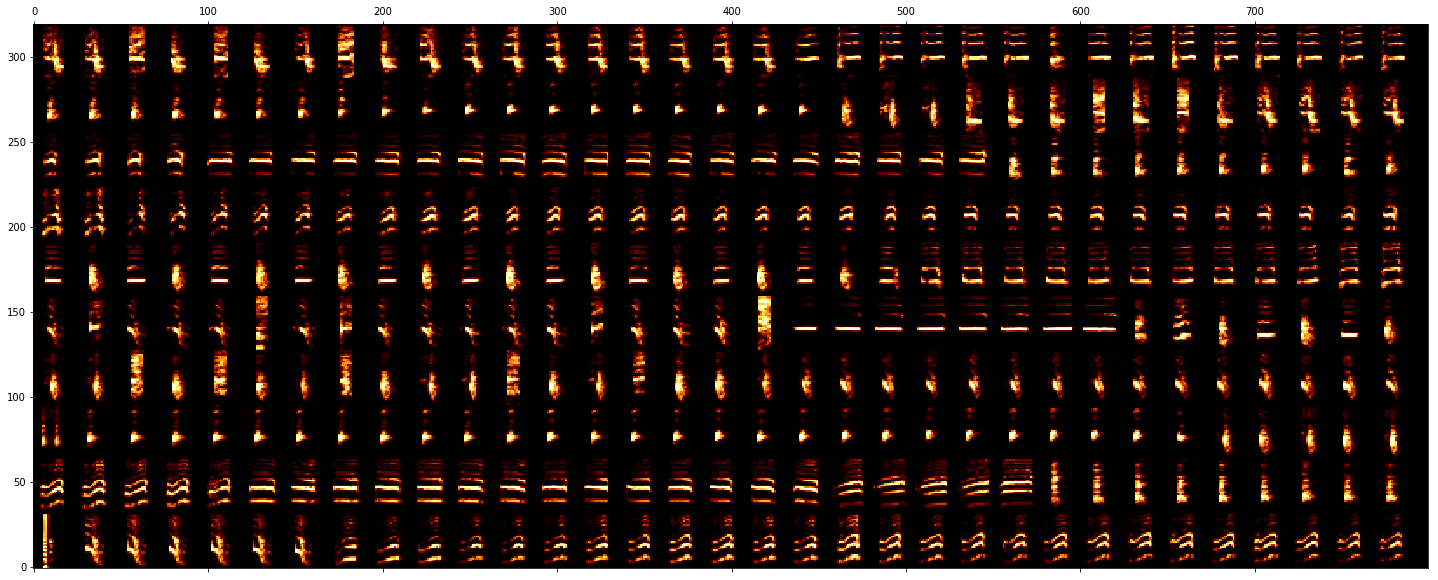

In [17]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

In [18]:
syllable_df['spectrogram'] = syllables_spec

In [19]:
# save 
syllable_df.to_pickle(df_loc)

In [20]:
syllable_df[:3]

start_time  end_time   indv  indvi                          key  \
0       0.000     0.036  bird3      0  bird3_0525_2004_04_19_16_06   
1       0.101     0.136  bird3      0  bird3_0525_2004_04_19_16_06   
2       0.208     0.247  bird3      0  bird3_0525_2004_04_19_16_06   

                                               audio   rate  \
0  [-0.013927590325060985, -0.09374820877158284, ...  48000   
1  [-0.08033924279200529, -0.1427361110642931, -0...  48000   
2  [0.20502230290406648, 0.16692246300221994, 0.1...  48000   

                                         spectrogram  
0  [[0, 0, 0, 0, 0, 0, 206, 254, 90, 0, 18, 0, 0,...  
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...

Text(0.5, 1.0, 'min')

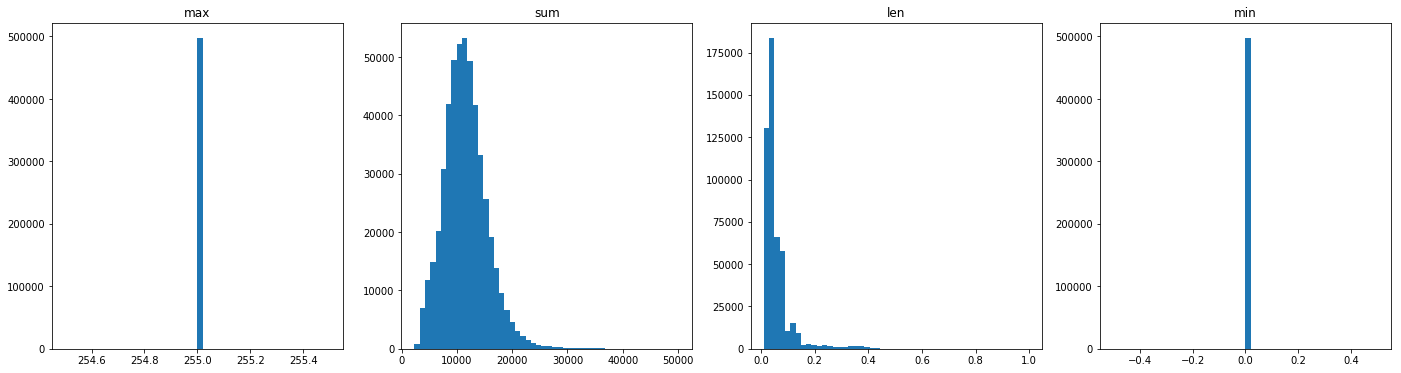

In [21]:
fig, axs = plt.subplots(ncols=4, figsize=(24,6))
axs[0].hist([np.max(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('max')
axs[1].hist([np.sum(i) for i in syllable_df.spectrogram.values], bins=50);axs[1].set_title('sum')
axs[2].hist((syllable_df.end_time - syllable_df.start_time).values, bins = 50); axs[2].set_title('len')
axs[3].hist([np.min(i) for i in syllable_df.spectrogram.values], bins=50);axs[3].set_title('min')

### cluster

bird3 132223
(25.0, 10) (320, 800) 25.0 32 800


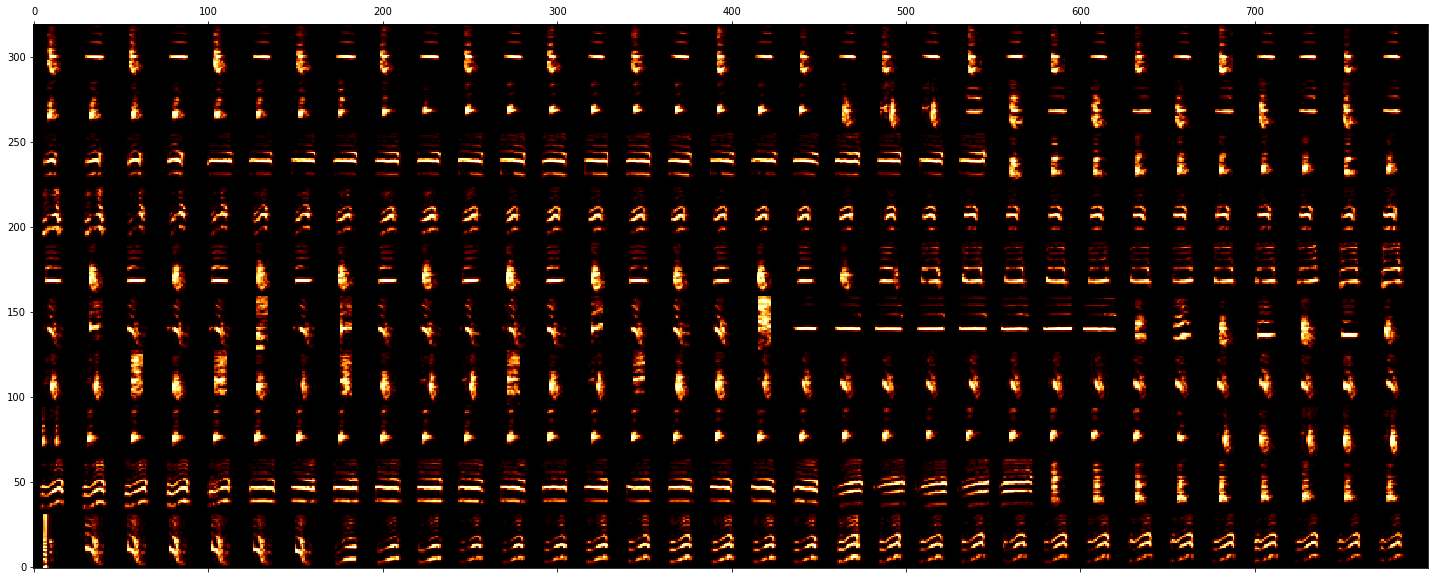

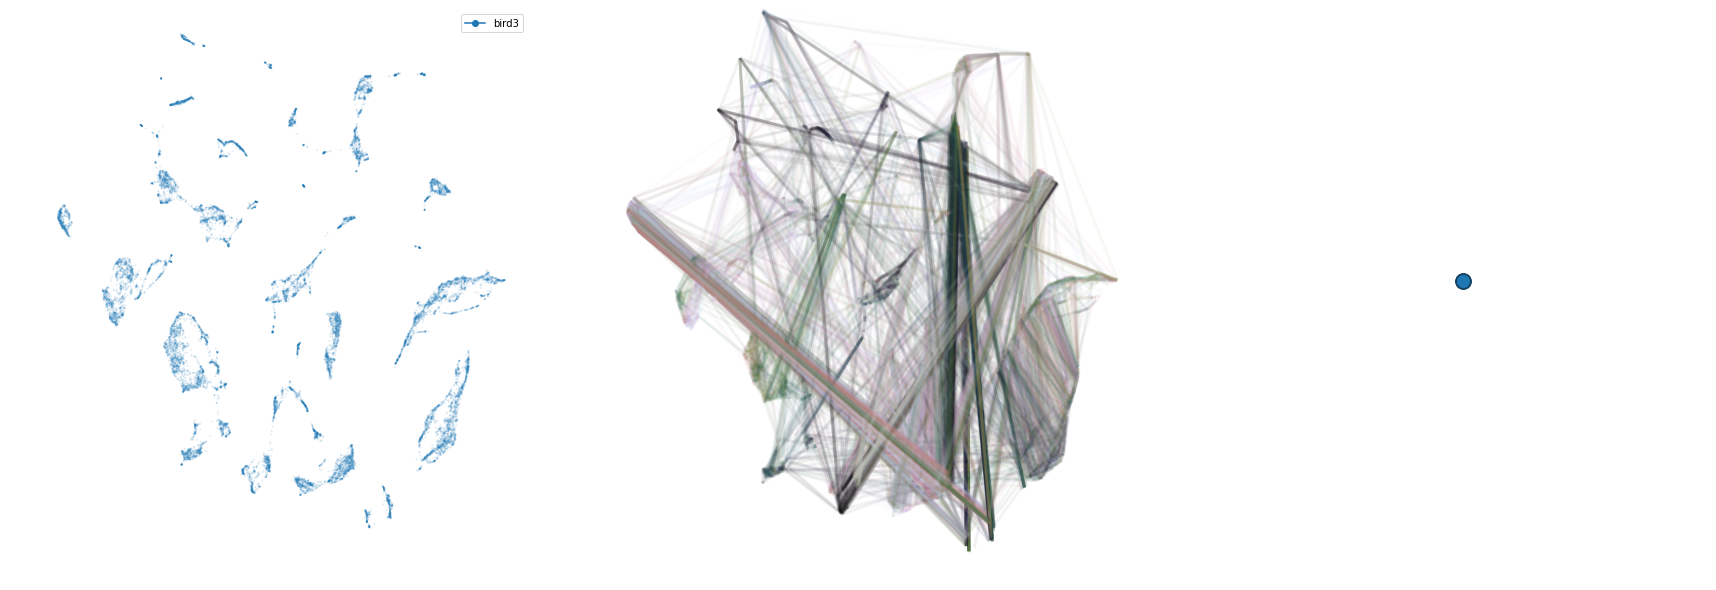

bird4 114634
(25.0, 10) (320, 800) 25.0 32 800


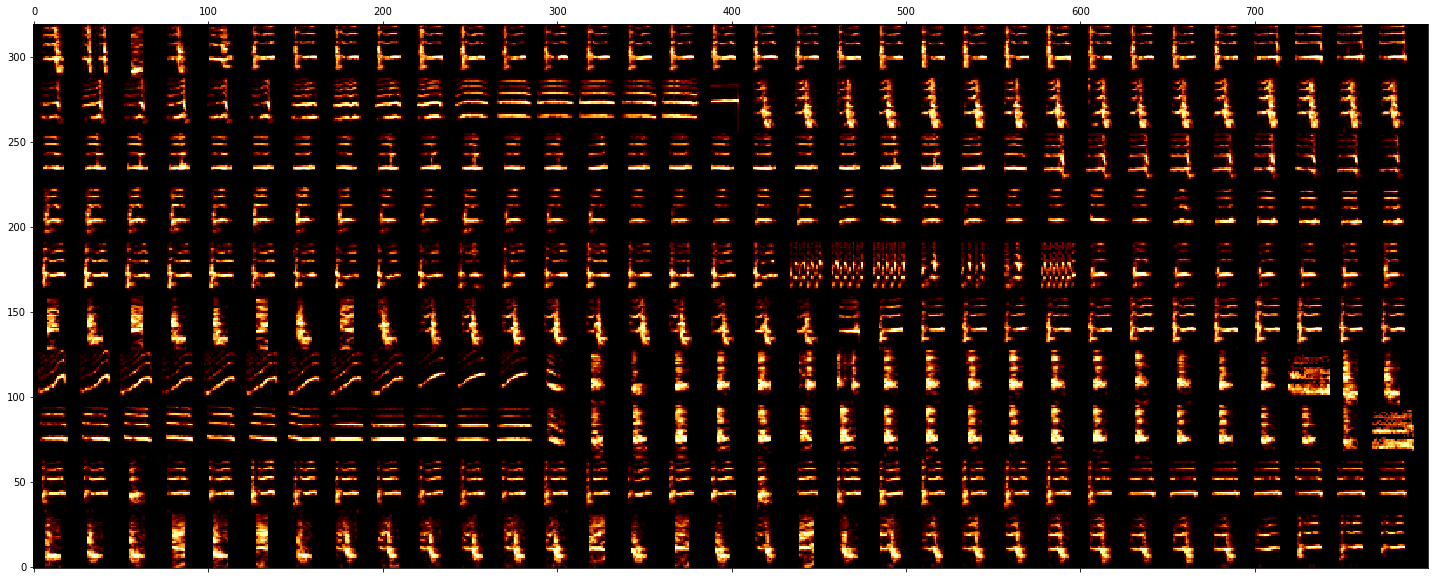

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


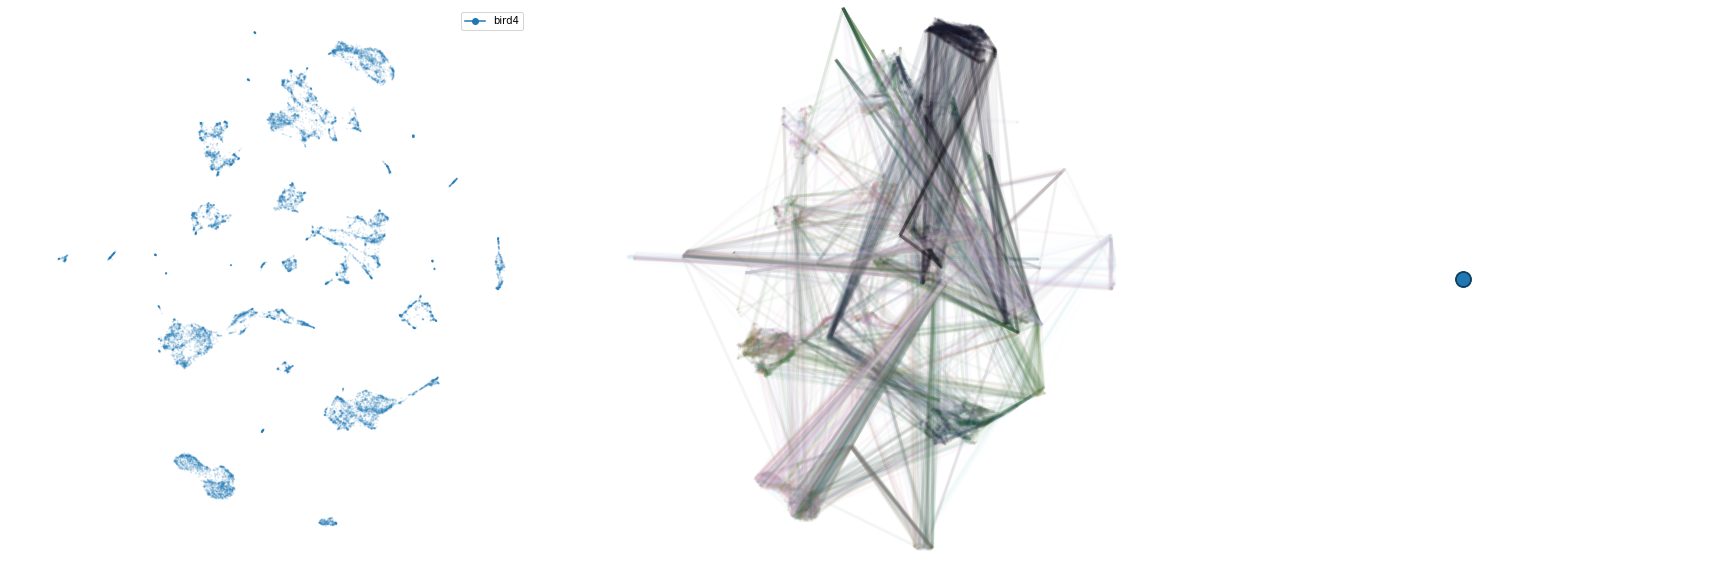

bird1 107319
(25.0, 10) (320, 800) 25.0 32 800


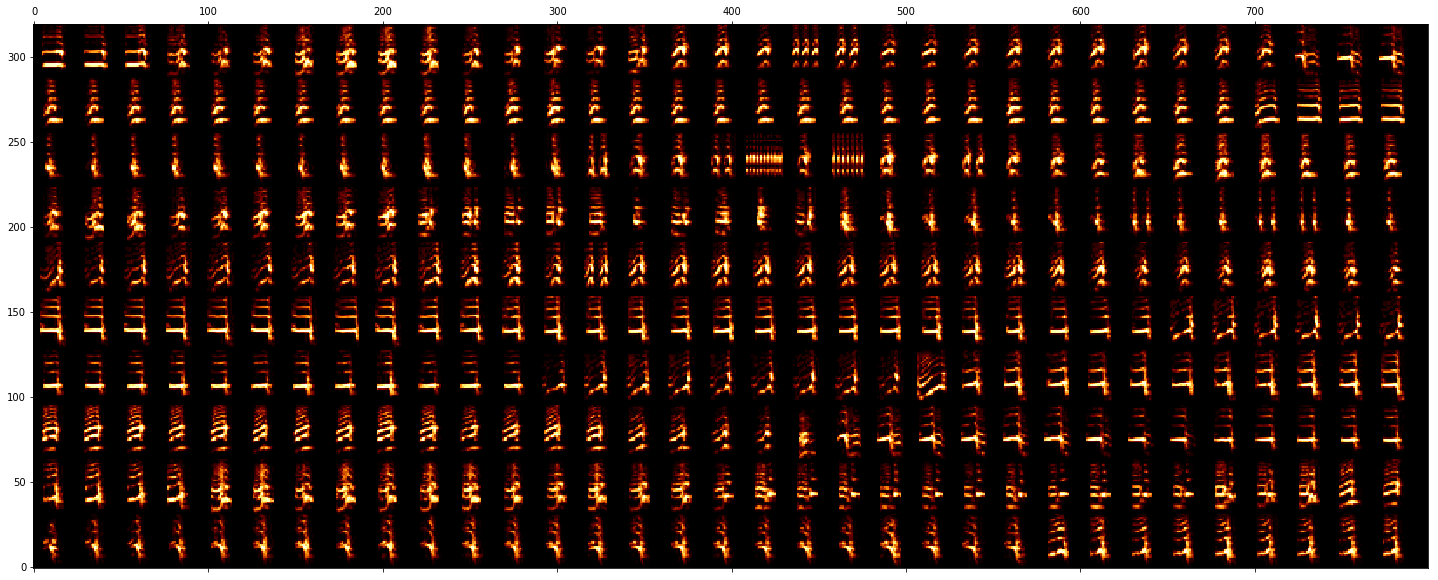

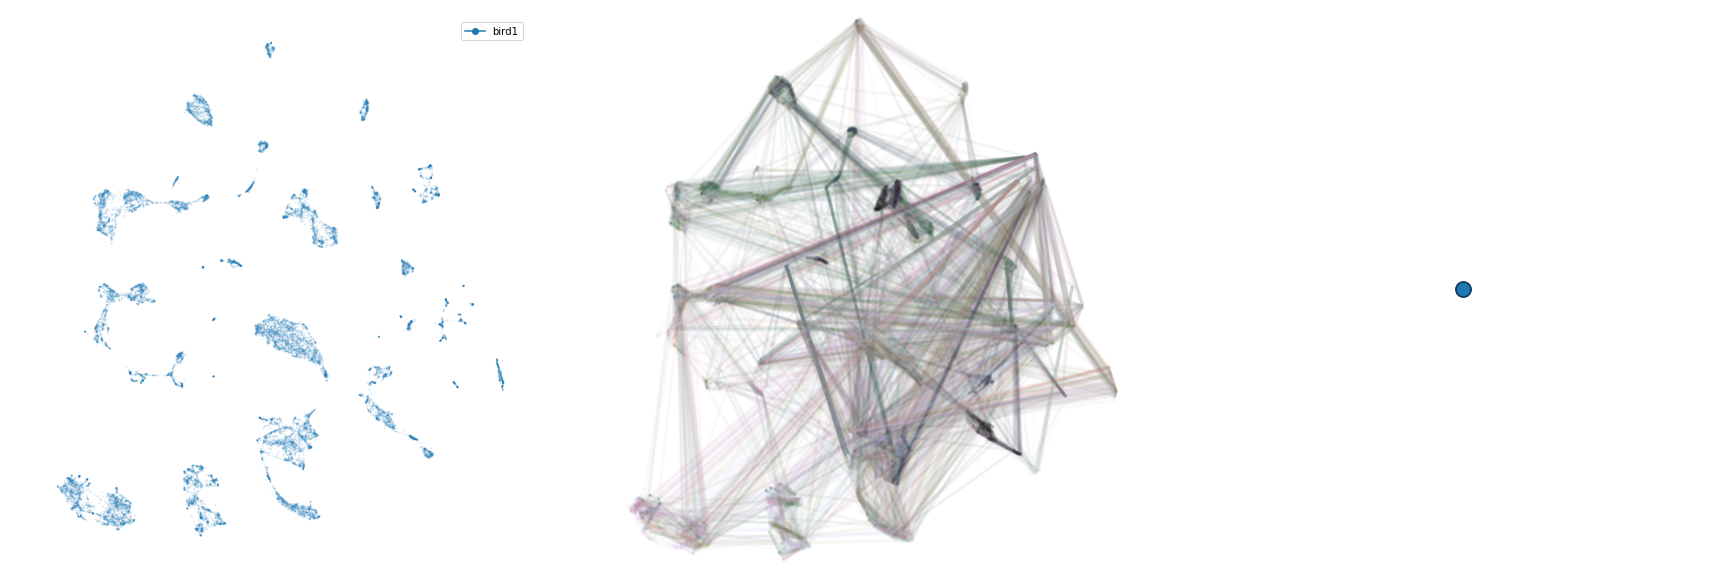

bird6 106088
(25.0, 10) (320, 800) 25.0 32 800


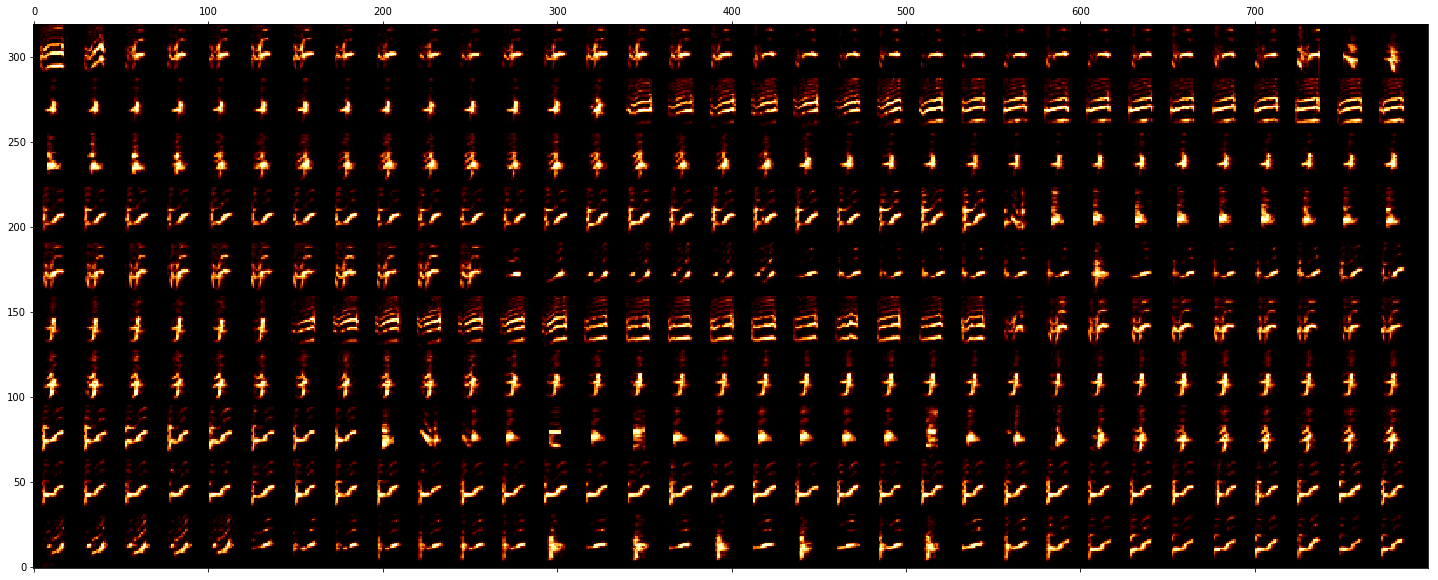

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


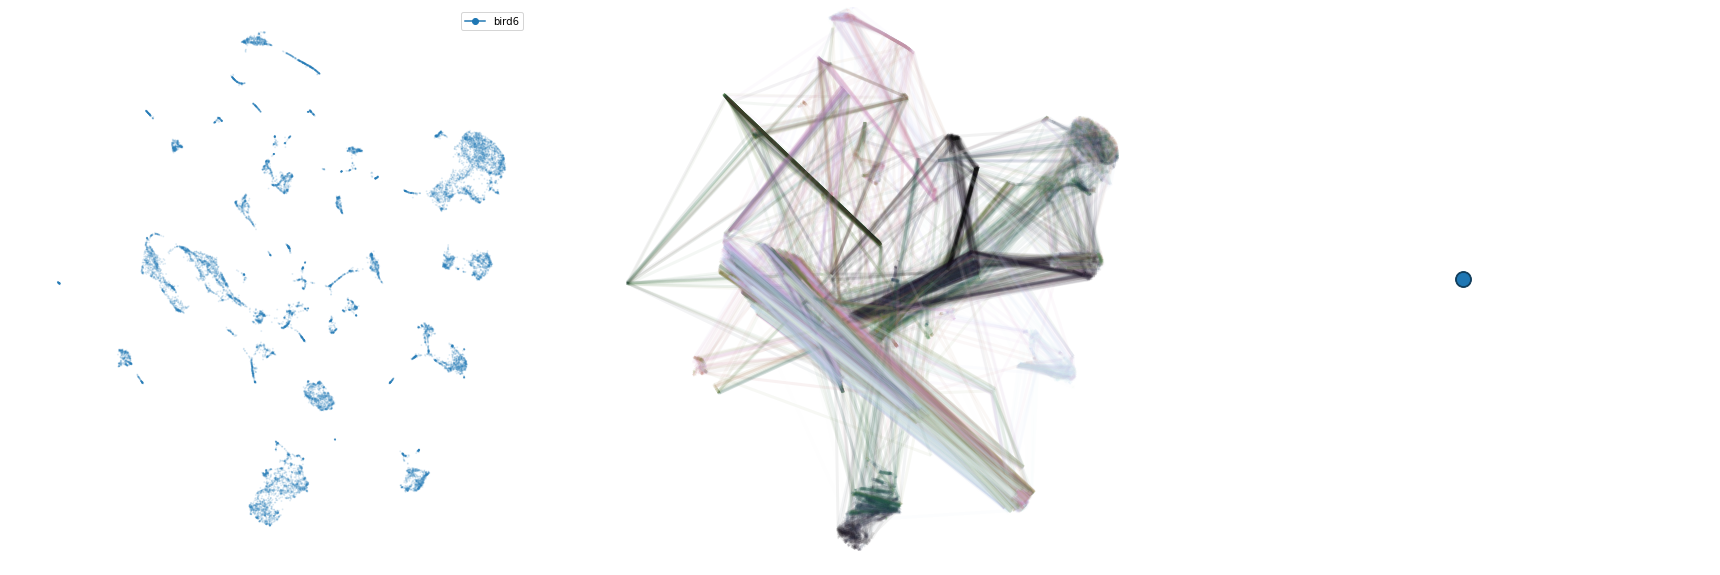

bird2 37043
(25.0, 10) (320, 800) 25.0 32 800


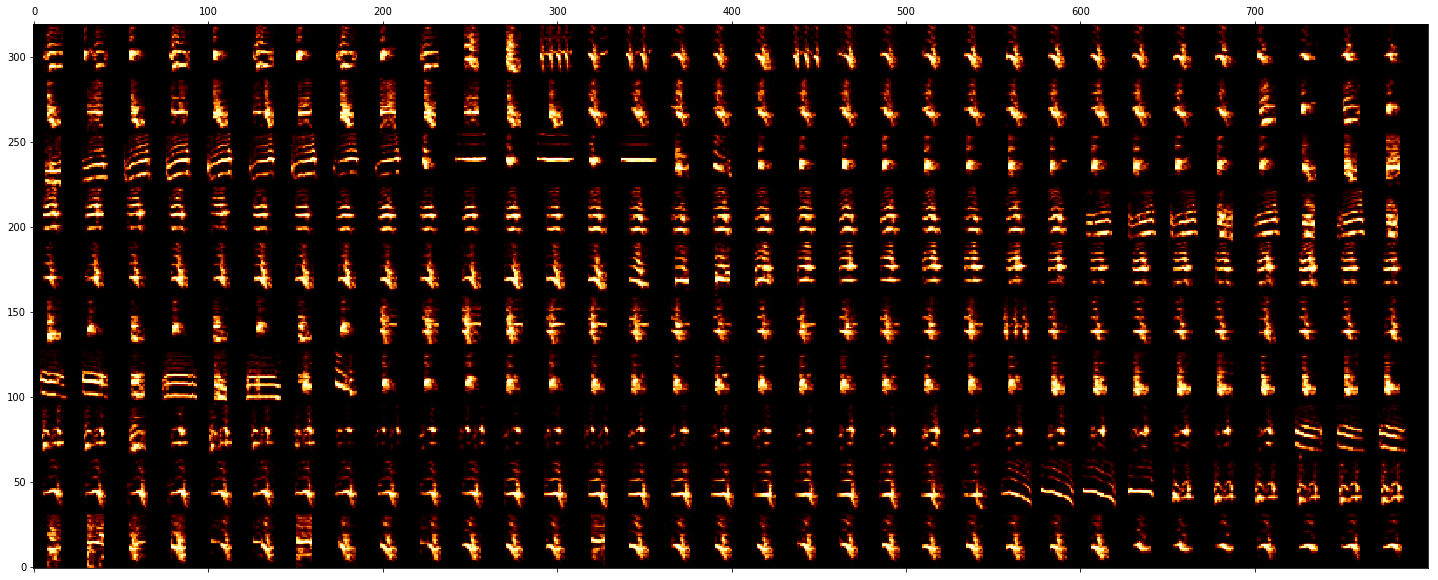

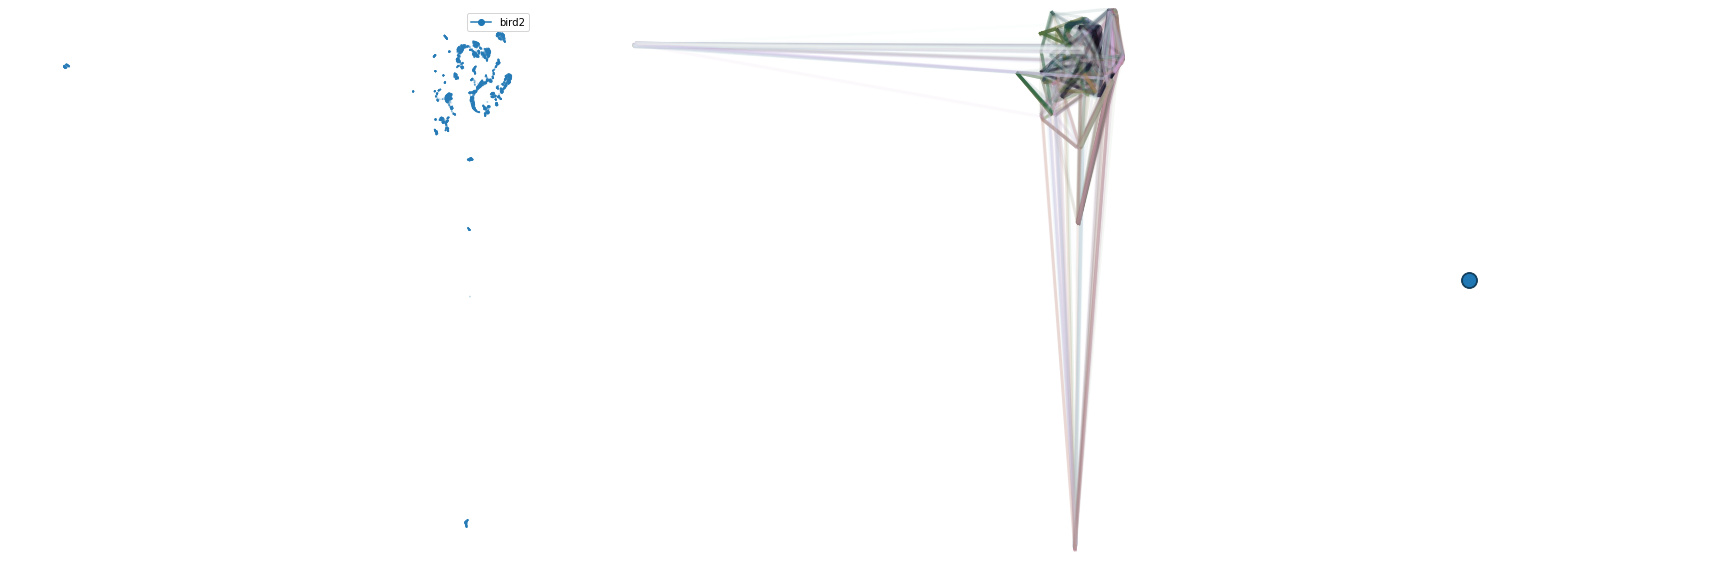

In [43]:
for indv in tqdm(syllable_df.indv.unique()):
    indv_df = syllable_df[syllable_df.indv == indv]
    print(indv, len(indv_df))
    indv_df = indv_df[:20000]
    specs = list(indv_df.spectrogram.values)
    draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)
    
    specs_flattened = flatten_spectrograms(specs)

    fit = umap.UMAP()
    z = list(fit.fit_transform(specs_flattened))
    indv_df["umap"] = z

    indv_df["syllables_sequence_id"] = None
    indv_df["syllables_sequence_pos"] = None
    indv_df = indv_df.sort_values(by=["key", "start_time"])
    for ki, key in enumerate(indv_df.key.unique()):
        indv_df.loc[indv_df.key == key, "syllables_sequence_id"] = ki
        indv_df.loc[indv_df.key == key, "syllables_sequence_pos"] = np.arange(
            np.sum(indv_df.key == key)
        )

    draw_projection_plots(indv_df, label_column="indv")
    #fig, ax = plt.subplots(figsize=(15,15))
    #scatter_projections(projection=z, alpha=1, labels = subset_sylls.labels.values, s=100, ax = ax)
    #ax.set_xlim([-15,15])
    #ax.set_ylim([-15,15])
    plt.show()

In [35]:
indv_df["umap"] = z

In [36]:
indv_df["syllables_sequence_id"] = None
indv_df["syllables_sequence_pos"] = None
indv_df = indv_df.sort_values(by=["key", "start_time"])
for ki, key in enumerate(indv_df.key.unique()):
    indv_df.loc[indv_df.key == key, "syllables_sequence_id"] = ki
    indv_df.loc[indv_df.key == key, "syllables_sequence_pos"] = np.arange(
        np.sum(indv_df.key == key)
    )

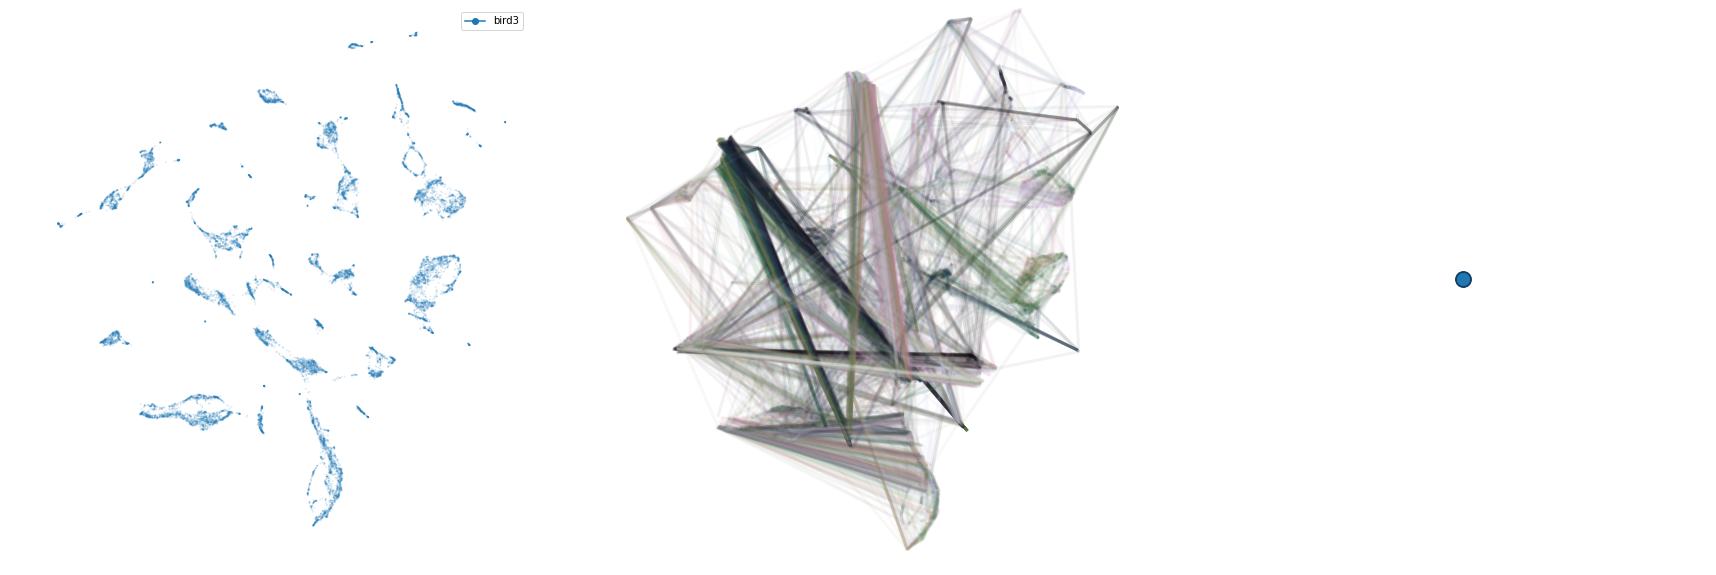

In [40]:
draw_projection_plots(indv_df, label_column="indv")

In [26]:
z  = np.vstack(z)

In [27]:
x[:3]

array([[ 2.1377676, -5.973106 ],
       [ 4.6151404, -4.2828717],
       [ 4.3605175, -4.0213723]], dtype=float32)

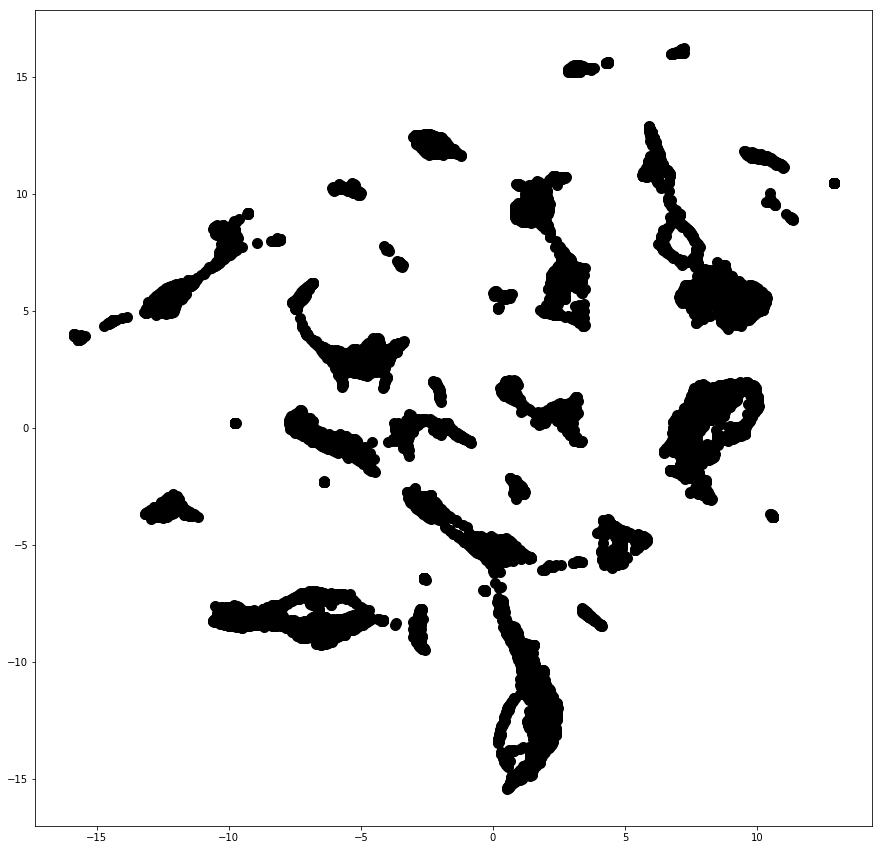

In [38]:
fig, ax = plt.subplots(figsize=(15,15))
scatter_projections(projection=x, alpha=1, labels = None, s=100, ax = ax)


In [15]:
len(syllable_df)

497307

In [14]:
specs = list(syllable_df.spectrogram.values)
specs = [i / np.max(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(497307, 768)

In [15]:
fit = umap.UMAP()

In [16]:
np.shape(specs_flattened)

(497307, 768)

In [ ]:
z  = list(fit.fit_transform(specs_flattened))

In [ ]:
z = np.vstack(z)

### variation across populations

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
scatter_projections(projection=z, alpha=1, labels = None, s=100, ax = ax)
plt.show()

In [30]:
syllable_df[:3]

start_time  end_time          labels indv  indvi  \
0         0.0  1.213917  isolation call  UNK      0   
0         0.0  0.737667      close call  UNK      0   
0         0.0  1.098792   suckling call  UNK      0   

                         key  \
0  Audio_S287_isolation_call   
0      Audio_S105_close_call   
0   Audio_S450_suckling_call   

                                               audio   rate  \
0  [-1.2798290802061346e-05, -7.027552779787061e-...  96000   
0  [-1.9724764766160915e-06, 9.316552547592764e-0...  96000   
0  [-3.1328436848193265e-06, -1.653114868834354e-...  96000   

                                         spectrogram  
0  [[0.0, 0.0, 0.0, 0.0028829596, -0.009689297, 0...  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 2.2376324e-05, -0.0...  
0  [[0.0, 0.0, 0.0, 0.0, 0.00026210205, 0.0034825...

### just look at a subset

In [47]:
n_top = 15

In [48]:
top_phrases = pd.DataFrame(
    {i: [sum(syllable_df.labels == i)] for i in syllable_df.labels.unique()}
).T.sort_values(by=0, ascending=False)[:n_top]
top_phrases.T

contact call  snort  begging scream  begging scream gradation  hum  growl  \
0            32     32              32                        30   30     29   

   hum gradation  contact call gradation  Ascending scream  begging call  \
0             29                      25                25            21   

   bark  whine  whistle  hah  isolation call  
0    21     20       19   17              16

In [49]:
top_phrases_list = list(top_phrases.index)

In [50]:
subset_sylls = syllable_df[syllable_df.labels.isin(top_phrases_list)]

In [51]:
len(subset_sylls)

378

In [52]:
specs = list(subset_sylls.spectrogram.values)
specs = [i / np.max(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(378, 992)

In [53]:
fit = umap.UMAP(min_dist=0.25)

In [54]:
np.shape(specs_flattened)

(378, 992)

In [55]:
z  = list(fit.fit_transform(specs_flattened))

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [56]:
z = np.vstack(z)

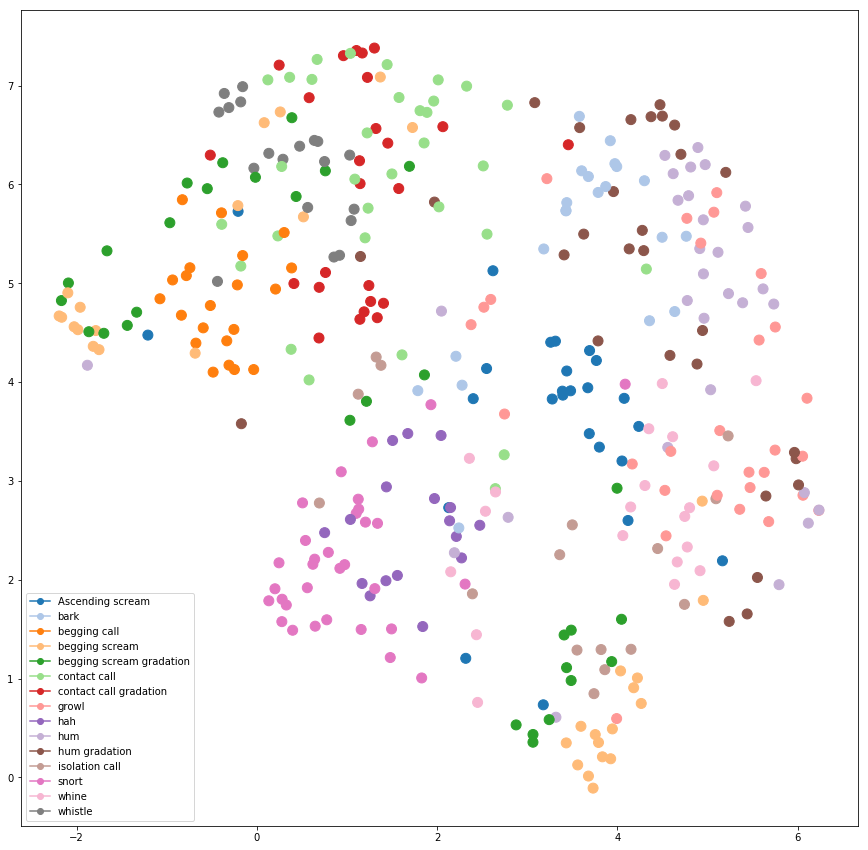

In [58]:
fig, ax = plt.subplots(figsize=(15,15))
scatter_projections(projection=z, alpha=1, labels = subset_sylls.labels.values, s=100, ax = ax)
#ax.set_xlim([-15,15])
#ax.set_ylim([-15,15])
plt.show()